# Notebook objective:
- To predict the forest cover type for a given 30 x 30 meter cell using a model trained on the "US Forest Service (USFS) Region 2 Resource Information System" and the "US Geological Survey" datasets

# Contents:
1. Import packages
2. Exploratory data analysis
3. Turn input data into right format for model training
4. Get model from previous project and train model
5. Plot performance metrics
6. Predict 10 images

# Other info
The covertypes are the following:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so existing forest cover types are mainly a result of ecological processes rather than forest management practices.

### Import packages

In [24]:
import tensorflow as tf
print(tf.__version__) #will print the version of your TensorFlow
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

2.8.0


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

### Exploratory data analysis

In [26]:
df = pd.read_csv("cover_data.csv")
df = df[['Elevation', 'Slope', 'Horizontal_Distance_To_Roadways', 'Wilderness_Area1', 'Wilderness_Area4', 'Soil_Type10','Soil_Type38', 'Soil_Type39', 'Soil_Type23','Soil_Type22', 'class']]
df.head()

,Elevation,Slope,Horizontal_Distance_To_Roadways,Wilderness_Area1,Wilderness_Area4,Soil_Type10,Soil_Type38,Soil_Type39,Soil_Type23,Soil_Type22,class
0,2596,3,510,1,0,0,0,0,0,0,5
1,2590,2,390,1,0,0,0,0,0,0,5
2,2804,9,3180,1,0,0,0,0,0,0,2
3,2785,18,3090,1,0,0,0,0,0,0,2
4,2595,2,391,1,0,0,0,0,0,0,5


In [27]:
df.describe()

,Elevation,Slope,Horizontal_Distance_To_Roadways,Wilderness_Area1,Wilderness_Area4,Soil_Type10,Soil_Type38,Soil_Type39,Soil_Type23,Soil_Type22,class
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,14.103704,2350.146611,0.448865,0.063627,0.056168,0.026803,0.023762,0.099399,0.057439,2.051471
std,279.984734,7.488242,1559.254870,0.497379,0.244087,0.230245,0.161508,0.152307,0.299197,0.232681,1.396504
min,1859.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,9.000000,1106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,13.000000,1997.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,18.000000,3328.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,66.000000,7117.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 11 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   Elevation                        581012 non-null  int64
 1   Slope                            581012 non-null  int64
 2   Horizontal_Distance_To_Roadways  581012 non-null  int64
 3   Wilderness_Area1                 581012 non-null  int64
 4   Wilderness_Area4                 581012 non-null  int64
 5   Soil_Type10                      581012 non-null  int64
 6   Soil_Type38                      581012 non-null  int64
 7   Soil_Type39                      581012 non-null  int64
 8   Soil_Type23                      581012 non-null  int64
 9   Soil_Type22                      581012 non-null  int64
 10  class                            581012 non-null  int64
dtypes: int64(11)
memory usage: 48.8 MB


#### Data distribution

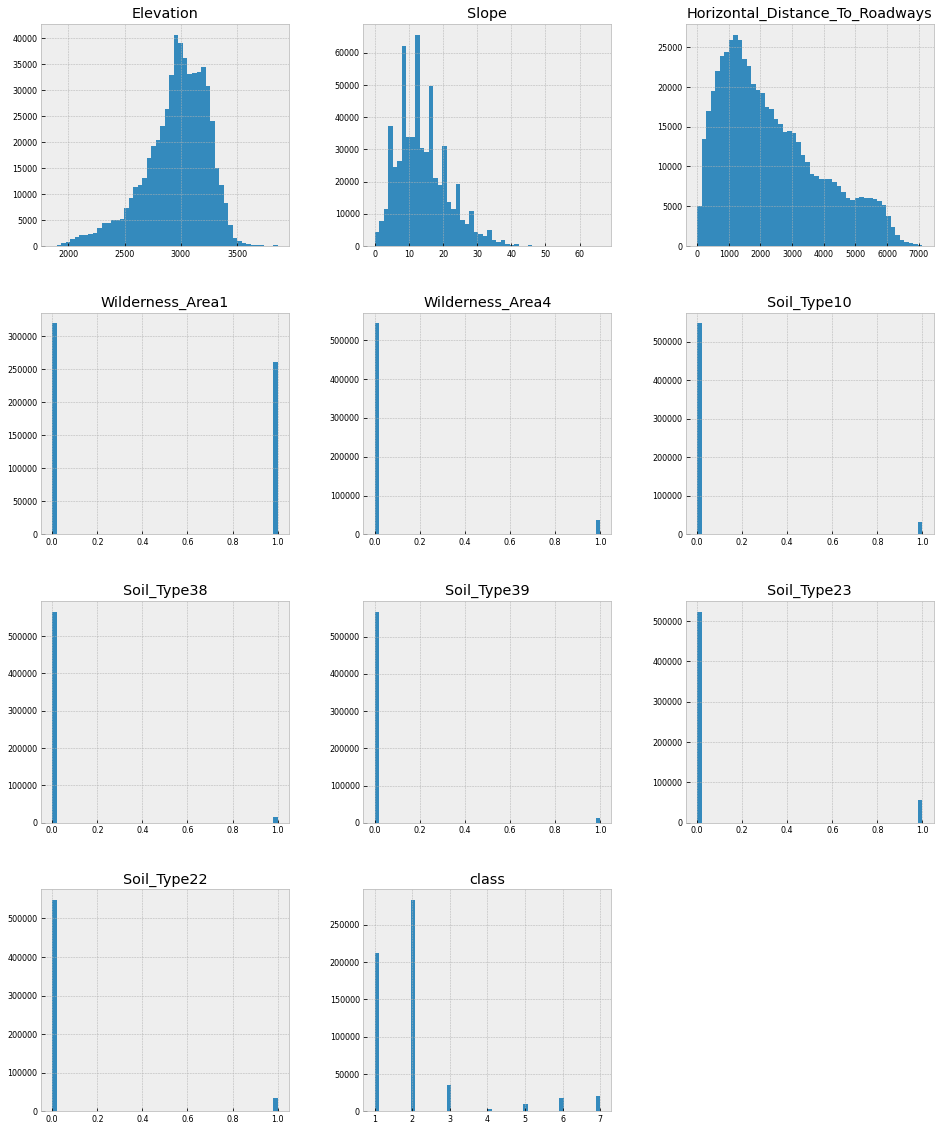

In [29]:
df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations


<AxesSubplot:>

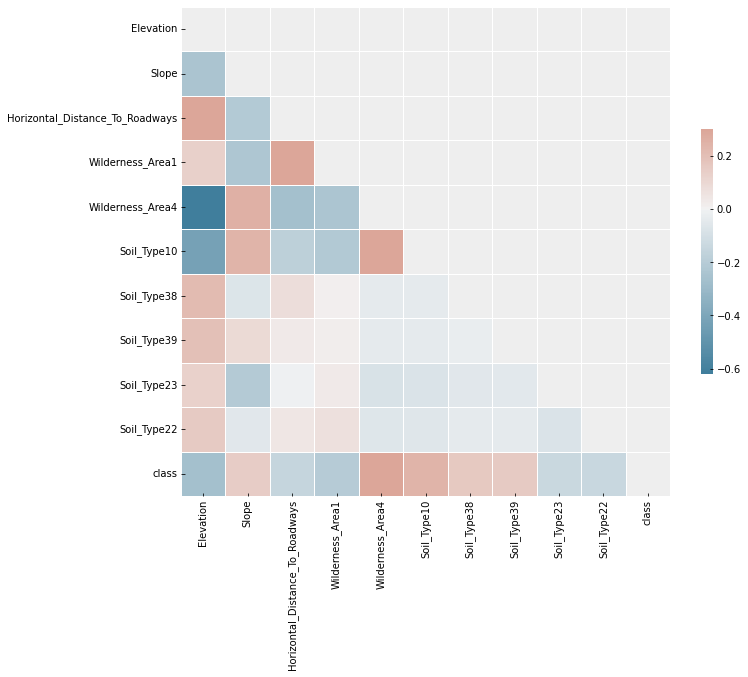

In [30]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

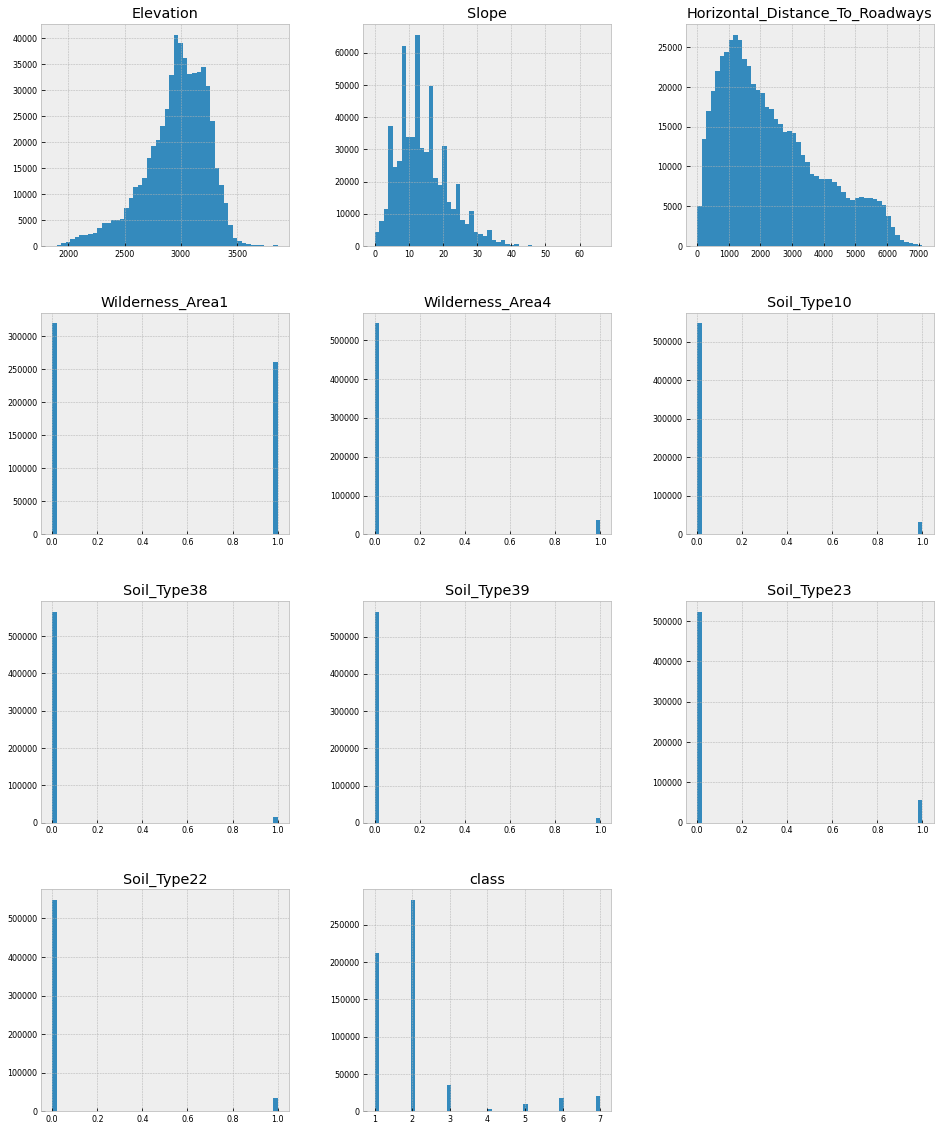

In [31]:
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

In [32]:
df_num_corr = df_num.corr()['class'][:-1] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > 0.13].sort_values(ascending=False)
print("There are {} strongly correlated values with class:\n{}".format(len(golden_features_list), golden_features_list))

There are 10 strongly correlated values with class:
Wilderness_Area4                   0.323200
Soil_Type10                        0.243876
Soil_Type38                        0.160170
Soil_Type39                        0.155668
Slope                              0.148285
Soil_Type23                       -0.135055
Soil_Type22                       -0.141746
Horizontal_Distance_To_Roadways   -0.153450
Wilderness_Area1                  -0.203913
Elevation                         -0.269554
Name: class, dtype: float64


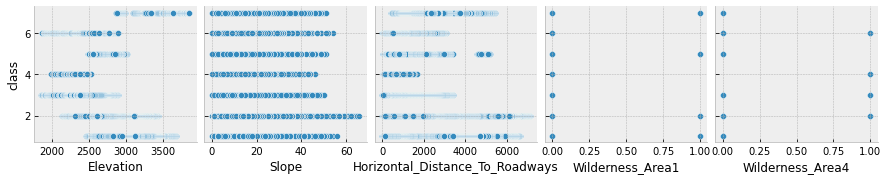

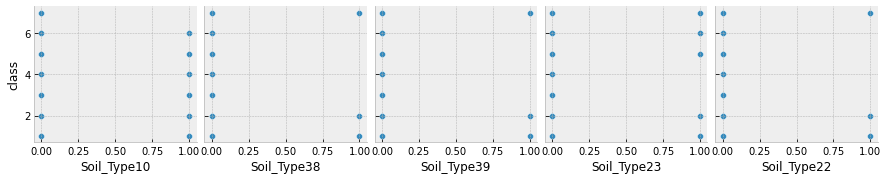

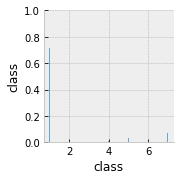

In [33]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['class'])

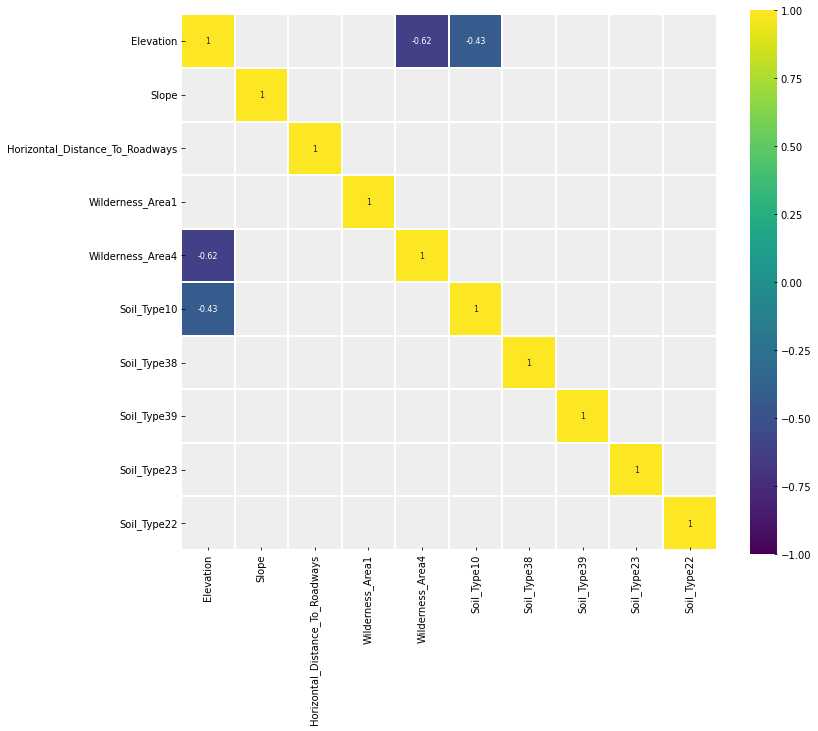

In [34]:
corr = df_num.drop('class', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [35]:
df['class'].describe()
print(df['class']. value_counts())

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: class, dtype: int64


Notes after EDA:
- No missing values
- No strong correlations with "class" (>0.5) but could boil features down to 10 with (>0.13)
- Will use softmax, not sigmoid, in last layer
- There are 7 classes, so if evenly distributed a monkey could get 14% predictions right
    - But classes not uniformly distributed, moslty 2s, so monkey could get __% of predictions right if it predicts all 2s

# Feature columns
- Use guide to create feature columns, soils will be one feature
- Later you can iterate removing some useless features
- Try making each soil column a numeric column at first

### 0 index the class column
because softmax activation works with 0 index labels

In [36]:
df['class'] = df['class'] - 1

### Split the dataframe into train, validation, and test

In [37]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

371847 train examples
92962 validation examples
116203 test examples


### Create an input pipeline using tf.data

Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly.

In [38]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(df, shuffle=True, batch_size=32):
  df = df.copy()
  labels = df.pop('class')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  return ds

In [39]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### Understand the input pipeline

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

In [40]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of Elevations:', feature_batch['Elevation'])
  print('A batch of classes:', label_batch )

Every feature: ['Elevation', 'Slope', 'Horizontal_Distance_To_Roadways', 'Wilderness_Area1', 'Wilderness_Area4', 'Soil_Type10', 'Soil_Type38', 'Soil_Type39', 'Soil_Type23', 'Soil_Type22']
A batch of Elevations: tf.Tensor([2365 2937 2821 3164 3308], shape=(5,), dtype=int64)
A batch of classes: tf.Tensor([1 1 1 0 0], shape=(5,), dtype=int64)


We can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

### View categorical columns inside

The categorical vocabulary columns provide a way to represent strings or categorical numbers as a one-hot vector. The vocabulary can be passed as a list using categorical_column_with_vocabulary_list, or loaded from a file using categorical_column_with_vocabulary_file.

Remember the rule: if a value of 2 is not twice as good as a value of 1 for that column, then that column is not numeric, it is categorical.

In [41]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [42]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [43]:
is_WildernessArea1 = feature_column.categorical_column_with_vocabulary_list(
      'Wilderness_Area1', [0, 1])

is_WildernessArea1_one_hot = feature_column.indicator_column(is_WildernessArea1)
demo(is_WildernessArea1_one_hot)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


### Create feature columns list

In [44]:
feature_columns = []

# numeric cols
for header in ['Elevation', 'Slope', 'Horizontal_Distance_To_Roadways']:
  feature_columns.append(feature_column.numeric_column(header))

In [45]:
# categorical cols
for header in ['Wilderness_Area1', 'Wilderness_Area4', 'Soil_Type10','Soil_Type38', 'Soil_Type39', 'Soil_Type23','Soil_Type22' ]:
  feature_columns.append(feature_column.numeric_column(header))

### Create feature layer

In [46]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [47]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### Create, compile, and train the model

In [48]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(7, activation='softmax') # Softmax for multi-class classification
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history= model.fit(train_ds,
          validation_data=val_ds,
          epochs=15)

Epoch 1/15
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
11617/11621 [============================>.] - ETA: 0s - loss: 1.9567 - accuracy: 0.4883WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Elevation': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=int64>, 'Slope': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>, 'Horizontal_Distance_To_Roadways': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>, 'Wilderness_Area1': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=int64>, 'Wilderness_Area4': <tf.Tensor 'IteratorGetNext:9' shape=(None,) dtype=int64>, 'Soil_Type10': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>, 'Soil_Type38': <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=int64>, 'Soil_Type39': <tf.Tensor 'IteratorGetNext:7' shape=(None,) dtype=int64>, 'Soil_Type23': <tf.Tensor 'IteratorGetNext:5' sha

In [49]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

3632/3632 [==============================] - 8s 2ms/step - loss: 1.2113 - accuracy: 0.4839
Accuracy 0.4839203953742981


### Plot performance metrics

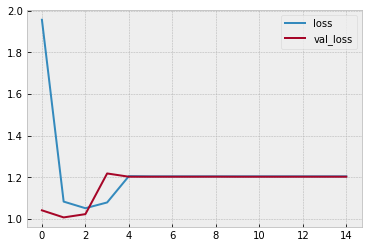

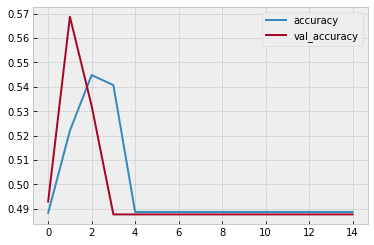

In [50]:
plt.figure()
plt.plot(history.history['loss'], label= 'loss' )
plt.plot(history.history['val_loss'], label= 'val_loss' )
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'], label= 'accuracy' )
plt.plot(history.history['val_accuracy'], label= 'val_accuracy' )
plt.legend()

### Predict 10 forest cover types

In [51]:
'''
image_path = '/home/jaimeggbfp/PycharmProjects/TestingBaseInt/data/h-or-s/happy/happy2-15.png'
img_PIL = image.load_img(image_path, target_size=(150,150))
img_arr = image.img_to_array(img_PIL); print(img_arr.shape)
img_disp = tf.keras.utils.array_to_img(img_arr); print(img_arr.shape)
img_res = img_arr / 255                           # REMEMBER TO RESCALE, OTHERWISE YOU'LL ALWAYS PREDICT 1s

plt.imshow(img_res)
plt.show()

img_ten = np.expand_dims(img_res, axis=0); print(img_ten.shape)         # model wants a 4D tensor
pred_idx = model(img_ten); print(pred_idx)

if pred_idx > 0.5:
    print('sad face')
else:
    print('happy face')
'''

"\nimage_path = '/home/jaimeggbfp/PycharmProjects/TestingBaseInt/data/h-or-s/happy/happy2-15.png'\nimg_PIL = image.load_img(image_path, target_size=(150,150))\nimg_arr = image.img_to_array(img_PIL); print(img_arr.shape)\nimg_disp = tf.keras.utils.array_to_img(img_arr); print(img_arr.shape)\nimg_res = img_arr / 255                           # REMEMBER TO RESCALE, OTHERWISE YOU'LL ALWAYS PREDICT 1s\n\nplt.imshow(img_res)\nplt.show()\n\nimg_ten = np.expand_dims(img_res, axis=0); print(img_ten.shape)         # model wants a 4D tensor\npred_idx = model(img_ten); print(pred_idx)\n\nif pred_idx > 0.5:\n    print('sad face')\nelse:\n    print('happy face')\n"

In [52]:
'''
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)
'''

'\nsample = {\n    \'Type\': \'Cat\',\n    \'Age\': 3,\n    \'Breed1\': \'Tabby\',\n    \'Gender\': \'Male\',\n    \'Color1\': \'Black\',\n    \'Color2\': \'White\',\n    \'MaturitySize\': \'Small\',\n    \'FurLength\': \'Short\',\n    \'Vaccinated\': \'No\',\n    \'Sterilized\': \'No\',\n    \'Health\': \'Healthy\',\n    \'Fee\': 100,\n    \'PhotoAmt\': 2,\n}\n\ninput_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}\npredictions = reloaded_model.predict(input_dict)\nprob = tf.nn.sigmoid(predictions[0])\n\nprint(\n    "This particular pet had a %.1f percent probability "\n    "of getting adopted." % (100 * prob)\n)\n'